In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [11]:
FEATURES = ["open-avg_vwap","cs_rank_open-avg_vwap*close-vwap","corr_hv_5","rank_std_high_5"]
TARGET = "ret3d"  
L = 10
VAL_START = pd.Timestamp("2024-01-01")
BATCH = 32
EPOCHS = 10

In [12]:
df = pd.read_csv("withfactor.csv")
df = df.copy()
df["日期"] = pd.to_datetime(df["日期"])
df = df.sort_values(["代號","日期"])

In [13]:
feat_mean = df[FEATURES].mean()
feat_std  = df[FEATURES].std().replace(0, 1.0)
df[FEATURES] = (df[FEATURES] - feat_mean) / feat_std

X_list, y_list, date_end, stock_end = [], [], [], []

for sid, g in df.groupby("代號", sort=False):
    g = g.sort_values("日期").reset_index(drop=True)
    feat_mat = g[FEATURES].to_numpy(dtype=np.float32)
    y_arr    = g[TARGET].to_numpy(dtype=np.float32)   

    for i in range(L-1, len(g)):
        X_seq = feat_mat[i-L+1:i+1, :]
        y_val = y_arr[i]
        if np.isnan(X_seq).any() or np.isnan(y_val):
            continue
        X_list.append(X_seq)
        y_list.append(y_val)
        date_end.append(g.loc[i, "日期"])
        stock_end.append(sid)

X    = np.array(X_list)
y    = np.array(y_list).reshape(-1, 1)
meta = pd.DataFrame({"日期": date_end, "代號": stock_end})

is_val = meta["日期"] >= VAL_START
X_tr, y_tr = X[~is_val], y[~is_val]
X_va, y_va = X[is_val],  y[is_val]
meta_va    = meta[is_val].reset_index(drop=True)

In [40]:
def sharpe_loss(y_true, y_pred):
    pnl = y_pred * y_true
    mean = tf.reduce_mean(pnl)
    std = tf.math.reduce_std(pnl)
    sharpe = mean / (std + 1e-6)
    return -sharpe

# --- LSTM 模型 ---
def build_lstm(input_len, n_feats, units=8):
    inp = layers.Input(shape=(input_len, n_feats))
    x = layers.LSTM(units)(inp)          
    x = layers.Dense(8, activation="relu")(x)
    x = layers.Dense(4, activation="relu")(x)
    out = layers.Dense(1, activation=None)(x)   
    model = models.Model(inp, out)
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
                  loss=sharpe_loss)
    return model

model = build_lstm(input_len=L, n_feats=len(FEATURES), units=8) 

model.fit(X_tr, y_tr,
          validation_data=(X_va, y_va),
          epochs=EPOCHS, batch_size=BATCH, verbose=1)

Epoch 1/10
28166/28166 [==============================] - 77s 3ms/step - loss: -0.0425 - val_loss: -0.0184
Epoch 2/10
28166/28166 [==============================] - 74s 3ms/step - loss: -0.0663 - val_loss: -0.0351
Epoch 3/10
28166/28166 [==============================] - 75s 3ms/step - loss: -0.0833 - val_loss: -0.0229
Epoch 4/10
28166/28166 [==============================] - 78s 3ms/step - loss: -0.0903 - val_loss: -0.0429
Epoch 5/10
28166/28166 [==============================] - 79s 3ms/step - loss: -0.0938 - val_loss: -0.0419
Epoch 6/10
28166/28166 [==============================] - 75s 3ms/step - loss: -0.0978 - val_loss: -0.0307
Epoch 7/10
28166/28166 [==============================] - 76s 3ms/step - loss: -0.1005 - val_loss: -0.0389
Epoch 8/10
28166/28166 [==============================] - 78s 3ms/step - loss: -0.1032 - val_loss: -0.0428
Epoch 9/10
28166/28166 [==============================] - 78s 3ms/step - loss: -0.1059 - val_loss: -0.0318
Epoch 10/10
28166/28166 [============

In [41]:
score_va = model.predict(X_va, batch_size=512).astype("float32").ravel()

out_va = meta_va.copy()       
out_va["score"]  = score_va
out_va["target"] = y_va.ravel()

460/460 [==============================] - 1s 2ms/step


In [42]:
score_va

array([ 0.6871952 ,  1.0734582 ,  1.0263621 , ..., -0.8082708 ,
       -0.70765936, -0.35753584], dtype=float32)

Win rate: 52.72%
Sharpe (ann.): 1.225
Max drawdown: -25.27%


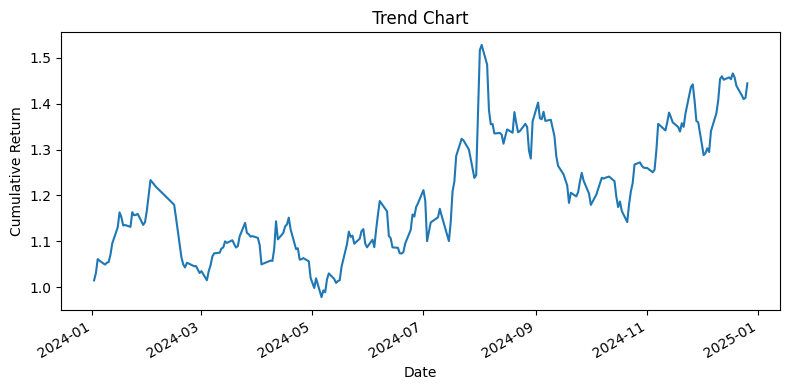

In [44]:
CAPITAL = 1_000_000         
COST_BPS = 15
LONG_N  = 0   
SHORT_N = 5  

daily = out_va.sort_values(["日期","score"], ascending=[True, False]).copy()
def make_weights(g):
    g = g.drop_duplicates("代號")
    frames = []

    if LONG_N > 0:
        long_ids = g.head(LONG_N)["代號"]
        frames.append(pd.DataFrame({"代號": long_ids, "w":  1.0 / LONG_N}))
    if SHORT_N > 0:
        short_ids = g.tail(SHORT_N)["代號"]
        frames.append(pd.DataFrame({"代號": short_ids, "w": -1.0 / SHORT_N}))

    if not frames:
        return pd.DataFrame(columns=["代號","w","日期"])

    w = (pd.concat(frames, ignore_index=True)
           .groupby("代號", as_index=False)["w"].sum())
    w["日期"] = g["日期"].iloc[0]
    return w

w_df = daily.groupby("日期", group_keys=False).apply(make_weights).reset_index(drop=True)
w_df = w_df.groupby(["日期","代號"], as_index=False)["w"].sum()
w_wide = (w_df.pivot_table(index="日期", columns="代號", values="w",
                           aggfunc="sum", fill_value=0.0)
          .sort_index())

ret_wide = (out_va[["日期","代號","target"]].drop_duplicates()
            .pivot_table(index="日期", columns="代號", values="target", aggfunc="first"))
ret_wide = ret_wide.reindex_like(w_wide).fillna(0.0)

# PnL & Fees
fee_unit = COST_BPS / 10000.0 
gross_pnl_series = (w_wide * ret_wide).sum(axis=1) * CAPITAL
fee_amt_series = (w_wide.abs().sum(axis=1) * (2 * fee_unit) * CAPITAL)
net_pnl_series = gross_pnl_series - fee_amt_series



# win rate / Sharpe / MaxDD（用淨報酬率）
net_ret_series = net_pnl_series / CAPITAL
win_rate = (net_ret_series > 0).mean()
avg = net_ret_series.mean()
std = net_ret_series.std(ddof=1)
sharpe = (avg / (std + 1e-12)) * np.sqrt(252)
cum = (1 + net_ret_series).cumprod()
max_dd = (cum / cum.cummax() - 1).min()

print(f"Win rate: {win_rate:.2%}")
print(f"Sharpe (ann.): {sharpe:.3f}")
print(f"Max drawdown: {max_dd:.2%}")

# 視覺化
plt.figure(figsize=(8,4))
cum.plot()
plt.title(" Trend Chart ")
plt.xlabel("Date"); plt.ylabel("Cumulative Return")
plt.tight_layout(); plt.show()